In [5]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
import time

In [6]:
# Import data
data_path = 'https://raw.githubusercontent.com/Rapo-zevs/eda/main/predictive_maintenance.csv'
data = pd.read_csv(data_path)
n = data.shape[0]
# First checks

data.info()
print('Number of null values is: {}'.format(data.isnull().sum().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
Number of null values is: 0


In [7]:
# Set numeric columns dtype to float
data['Tool wear [min]'] = data['Tool wear [min]'].astype('float64')
data['Rotational speed [rpm]'] = data['Rotational speed [rpm]'].astype('float64')

In [8]:
# Drop ID columns
df = data.copy()
df.drop(columns=['UDI','Product ID'], inplace=True)

The following pie chart shows the percentages of machines by Type:

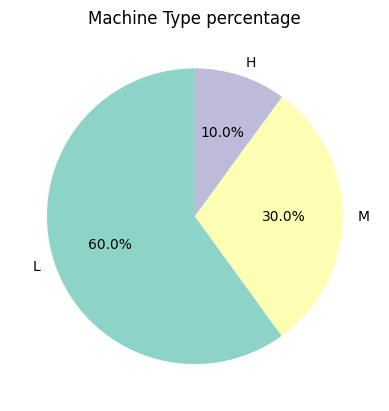

In [9]:
value = data['Type'].value_counts()
Type_Percentage = 100*value/data.Type.shape[0]
labels = Type_Percentage.index.array
x = Type_Percentage.array
custom_colors = sns.color_palette('Set3', len(labels))
plt.pie(x, labels=labels, colors=custom_colors, autopct='%1.1f%%', startangle=90)
plt.title('Machine Type percentage')
plt.show()

In [10]:
#Aberrations Create lists of features and target names
df.dtypes
features = [col for col in df.columns if df[col].dtype=='float64' or col =='Type']
target = ['Target','Failure Type']
# Portion of data where Random Failure=1
random_fail_index=df.loc[df['Failure Type']=='Random Failures'].index
df.loc[random_fail_index]

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
1221,M,297.0,308.3,1399.0,46.4,132.0,0,Random Failures
1302,L,298.6,309.8,1505.0,45.7,144.0,0,Random Failures
1748,H,298.4,307.7,1626.0,31.1,166.0,0,Random Failures
2072,L,299.6,309.5,1570.0,35.5,189.0,0,Random Failures
2559,L,299.3,309.0,1447.0,50.4,140.0,0,Random Failures
3065,M,300.1,309.2,1687.0,27.7,95.0,0,Random Failures
3452,H,301.6,310.5,1602.0,32.3,2.0,0,Random Failures
5471,L,302.7,312.3,1346.0,61.2,170.0,0,Random Failures
5489,L,302.6,312.1,1499.0,35.0,215.0,0,Random Failures
5495,H,302.9,312.5,1357.0,55.0,12.0,0,Random Failures


Fortunately the machine failure RNF occurs in only 18 observations and it has a random nature
therefore not predictable so we decide to remove these rows.

In [11]:
# Drop RNF
df.drop(index=random_fail_index, inplace=True)

Going forward we find out that in 9 observations Machine failure is set to 1 when all types
of failures are set to 0. We cannot understand if there really was a failure or not so let’s remove
these observations too.

In [12]:
# Portion of data where Machine failure=1 but no failure cause is specified
ambiguous_index = df.loc[(df['Target']==1) & (df['Failure Type']=='No Failure')].index
second_drop = df.loc[ambiguous_index].shape[0]
display(df.loc[ambiguous_index,target])
df.drop(index=ambiguous_index, inplace=True)

,Target,Failure Type
1437,1,No Failure
2749,1,No Failure
4044,1,No Failure
4684,1,No Failure
5536,1,No Failure
5941,1,No Failure
6478,1,No Failure
8506,1,No Failure
9015,1,No Failure


In [13]:
# Global percentage of removed observations
print('Global percentage of removed observations:',
     (100*(data.size-df.size)/data.size))
df.reset_index(drop=True, inplace=True)   # Reset index
n = df.shape[0]

Global percentage of removed observations: 20.216


## Outliers inspection <a id="outliers"></a>


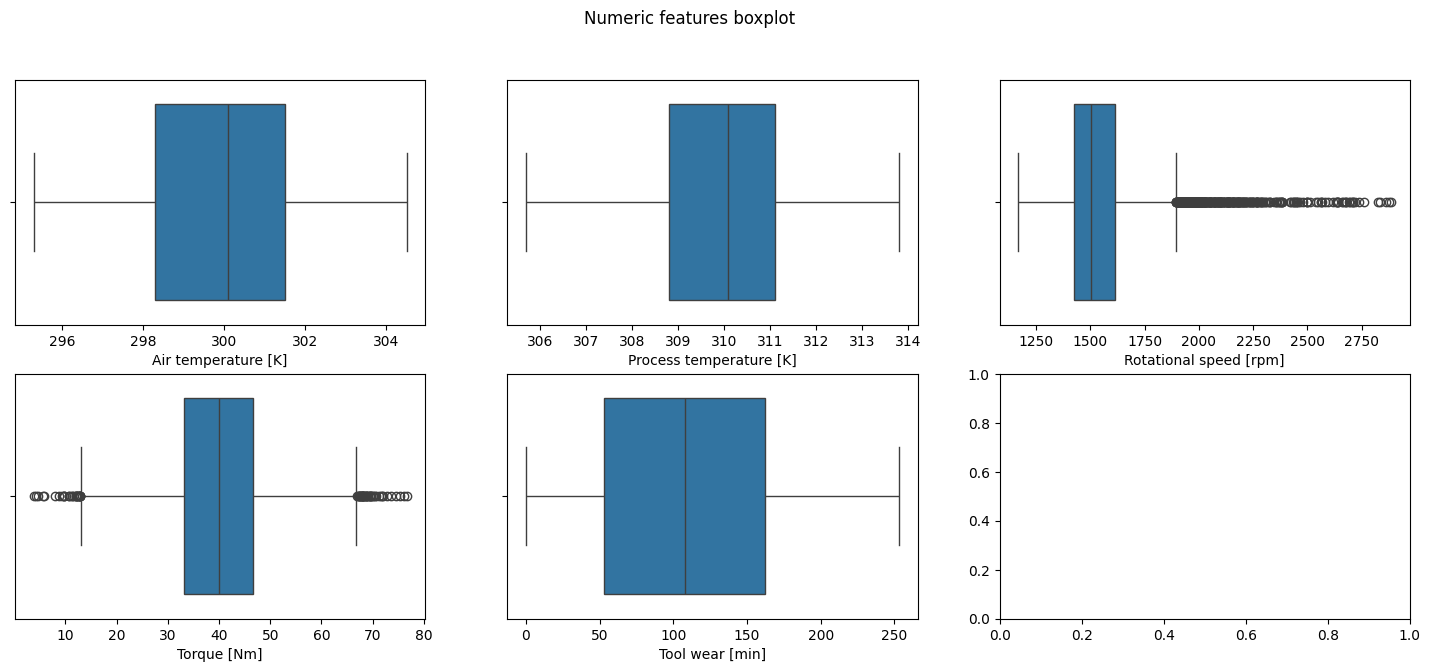

In [14]:
num_features = [feature for feature in features if df[feature].dtype=='float64']
# boxplot of numeric features
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features boxplot')
for j, feature in enumerate(num_features):
    sns.boxplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

In [15]:
def drop_outliers_custom(dataframe, column_name, lower_threshold, upper_threshold):
    # Filter the DataFrame to keep only the data points within the specified range
    dataframe_filtered = dataframe[(dataframe[column_name] >= lower_threshold) & (dataframe[column_name] <= upper_threshold)]
    return dataframe_filtered

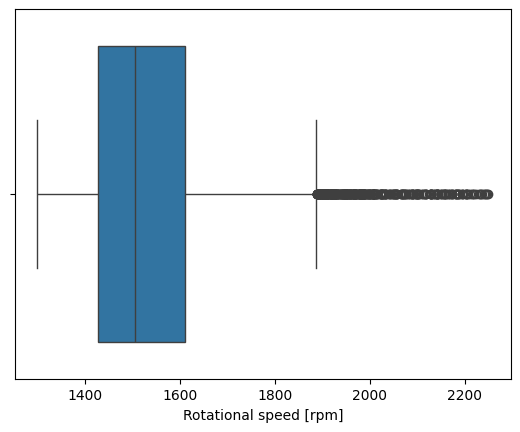

In [16]:
df = drop_outliers_custom(df, 'Rotational speed [rpm]', 1300, 2250)
sns.boxplot(x='Rotational speed [rpm]', data=df)
plt.show() 

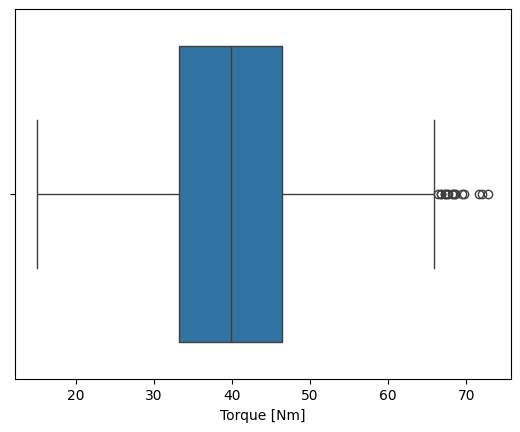

In [17]:
df = drop_outliers_custom(df, 'Torque [Nm]', 12, 73)
sns.boxplot(x='Torque [Nm]', data=df)
plt.show() 

### Resampling with SMOTE <a id="resampling"></a>

Another important consideration regards the extremely low occurrence of machine failures among
the entire dataset, which percentage is equal only to 3.31%. Moreover, a pie plot showing the
occurrence of the causes involved for each failure reveals a further degree of imbalance.

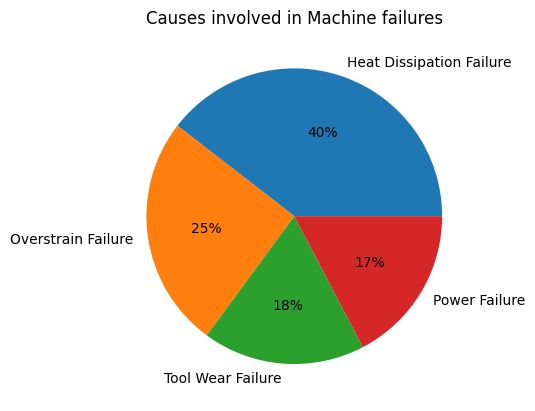

In [18]:
# Portion of df where there is a failure and causes percentage
fail_index = df.loc[df['Failure Type'] != 'No Failure'].index
df_fail = df.loc[fail_index]
df_fail_percentage = 100*df_fail['Failure Type'].value_counts()/df_fail['Failure Type'].shape[0]
# Pie plot
plt.title('Causes involved in Machine failures')
plt.pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()

In [19]:
from imblearn.over_sampling import SMOTENC
# n_working must represent 80% of the desired length of resampled dataframe
n_working = df['Failure Type'].value_counts()['No Failure']
desired_length = round(n_working/0.8)
spc = round((desired_length-n_working)/4)  #samples per class
# Resampling
balance_cause = {'No Failure':n_working,
                 'Overstrain Failure':spc,
                 'Heat Dissipation Failure':spc,
                 'Power Failure':spc,
                 'Tool Wear Failure':spc}
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)
df_res, y_res = sm.fit_resample(df, df['Failure Type'])

### Comparison after resampling <a id="resample_comparison"></a>

The result is described in the following pie charts.

In [20]:
# Portion of df_res where there is a failure and causes percentage
idx_fail_res = df_res.loc[df_res['Failure Type'] != 'No Failure'].index
df_res_fail = df_res.loc[idx_fail_res]
fail_res_percentage = 100*df_res_fail['Failure Type'].value_counts()/df_res_fail.shape[0]

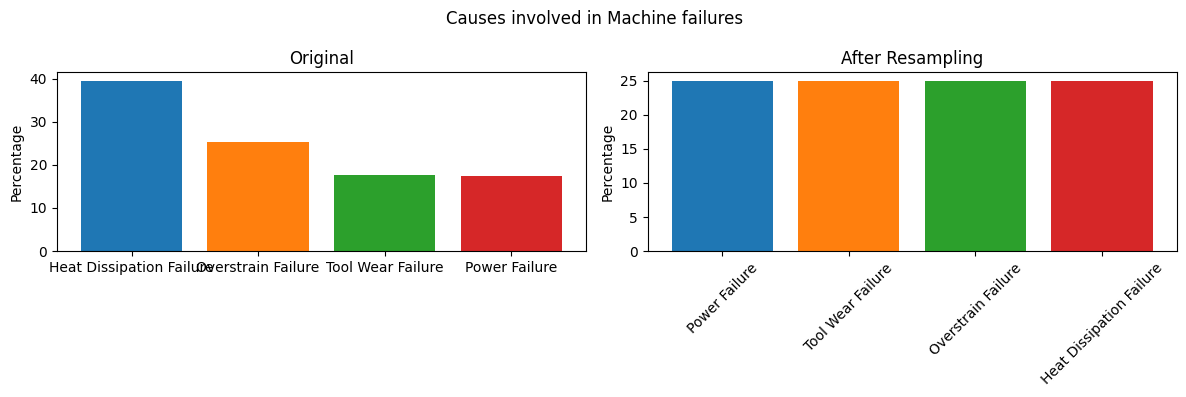

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.suptitle('Causes involved in Machine failures')

# Create bar charts on the first subplot
axs[0].bar(df_fail_percentage.index.array, df_fail_percentage.array, color=sns.color_palette('tab10')[0:4])
axs[0].set_ylabel('Percentage')
axs[0].set_title('Original')

# Create bar charts on the second subplot
axs[1].bar(fail_res_percentage.index.array, fail_res_percentage.array, color=sns.color_palette('tab10')[0:4])
axs[1].set_ylabel('Percentage')
axs[1].set_title('After Resampling')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Features scaling and Encoding <a id="encoding"></a>

In order to make data exploitable for the algorithms we will run, we apply two transformations:
* First, we apply a label encoding to the categorical columns, since Type is an ordinal feature
and Cause must be represented in one column. The mapping follows this scheme:
Type: {L=0, M=1, H=2}
Cause: {Working=0, PWF=1, OSF=2, HDF=3, TWF=4}
* Secondly we perform the scaling of the columns with StandardScaler. This is particularly
useful for the good working of methods that rely on the metric space, such as PCA and KNN.
It has been also verified that using StandardScaler leads to slightly better performances than
using MinMaxScaler.

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sc = StandardScaler()
types = {'L': 0, 'M': 1, 'H': 2}
causes = {'No Failure': 0,'Power Failure': 1,'Overstrain Failure': 2,'Heat Dissipation Failure': 3,'Tool Wear Failure': 4}
df_pre = df_res.copy()
# Encoding
df_pre['Type'].replace(to_replace=types, inplace=True)
df_pre['Failure Type'].replace(to_replace=causes, inplace=True)
# Scaling
df_pre[num_features] = sc.fit_transform(df_pre[num_features]) 

### PCA and Correlation Heatmap <a id="pca"></a>

We run PCA to have a further way of displaying the data instead of making feature selection.

In [23]:
pca = PCA(n_components=len(num_features))
X_pca = pd.DataFrame(data=pca.fit_transform(df_pre[num_features]), columns=['PC'+str(i+1) for i in range(len(num_features))])
var_exp = pd.Series(data=100*pca.explained_variance_ratio_, index=['PC'+str(i+1) for i in range(len(num_features))])
print('Explained variance ratio per component:', round(var_exp,2), sep='\n=')
 

Explained variance ratio per component:
=PC1    37.95
PC2    36.81
PC3    19.94
PC4     2.70
PC5     2.60
dtype: float64


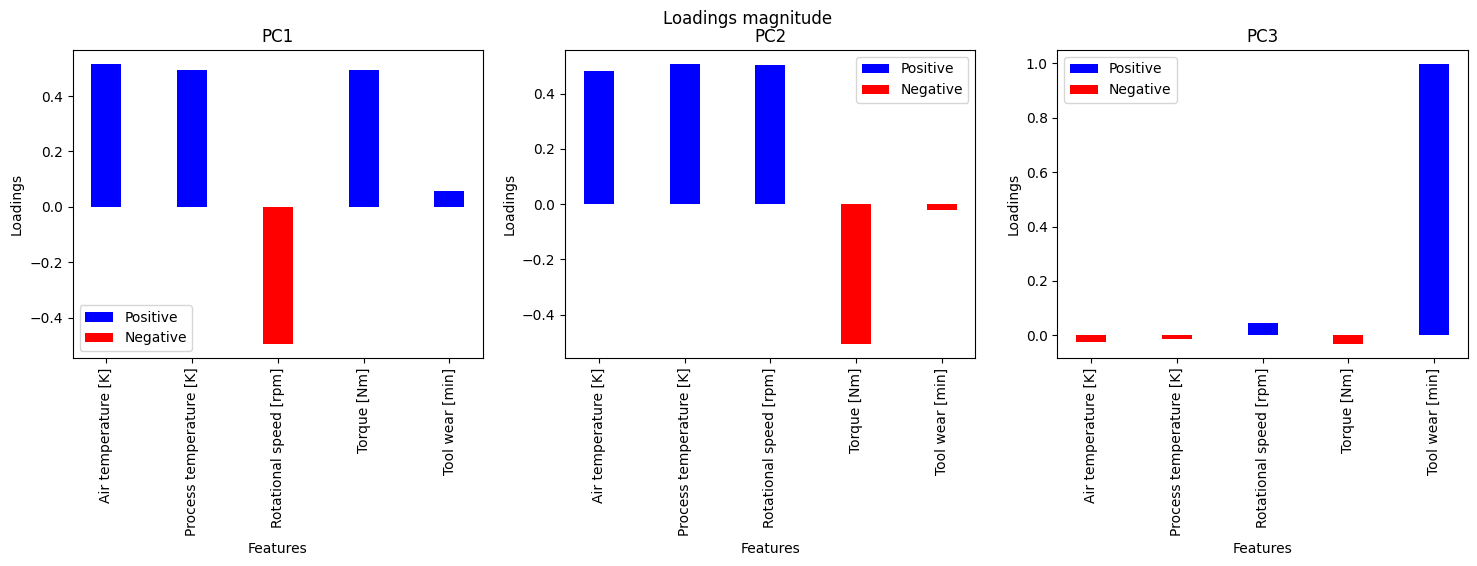

In [24]:
# Loadings Analysis
fig, axs = plt.subplots(ncols=3, figsize=(18, 4))
fig.suptitle('Loadings magnitude')
pca_loadings = pd.DataFrame(data=pca.components_, columns=num_features)

for j in range(3):
    ax = axs[j]
    loadings_data = pca_loadings.values[j]
    positive_loadings = np.maximum(0, loadings_data)
    negative_loadings = np.minimum(0, loadings_data)
    
    x = np.arange(len(num_features))
    width = 0.35
    
    ax.bar(x, positive_loadings, width, label='Positive', color='b')
    ax.bar(x, negative_loadings, width, label='Negative', color='r')
    
    ax.set_xlabel('Features')
    ax.set_ylabel('Loadings')
    ax.set_title('PC' + str(j + 1))
    ax.set_xticks(x)
    ax.set_xticklabels(num_features, rotation=90)
    ax.legend()

plt.show()


The bar plot of Principal Components weights makes easy to understand what they represent:
* PC1 is closely related to the two temperature data;
* PC2 can be identified with the machine power, which is the product of Rotational Speed
and Torque;
* PC3 is identifiable with Tool Wear.

In [25]:
# Feature Engineering
df_pre

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,-1.017742,-1.004959,0.224697,0.071780,-1.730475,0,0
1,0,-0.967193,-0.934918,-0.684593,0.394211,-1.686190,0,0
2,0,-1.017742,-1.074999,-0.112313,0.679793,-1.656666,0,0
3,0,-0.967193,-1.004959,-0.525626,-0.232226,-1.627143,0,0
4,0,-0.967193,-0.934918,-0.684593,-0.186165,-1.597620,0,0
...,...,...,...,...,...,...,...,...
11790,1,0.906437,1.007534,0.827517,-0.834734,1.587937,1,4
11791,0,1.257676,1.307356,-0.524258,0.349622,1.382287,1,4
11792,2,-0.862411,-0.839551,-1.089703,0.329286,1.540220,1,4
11793,0,-0.685989,-0.120660,0.130010,-0.425825,1.371319,1,4


The projection into the space generated by these three axes highlights that:
* TWF is the class of failures best separated from all the others and seems to depend almost
entirely on PC3 (Tool Wear);
* PWF occupies two extreme bands along the PC2 (Power), it is independent of the other
two components;
18
* The OSF and HDF classes are less separated than the others even if it can be observed
that the first is characterized by a high Tool Wear and low power while the second is
characterized by a high temperature and a low power.

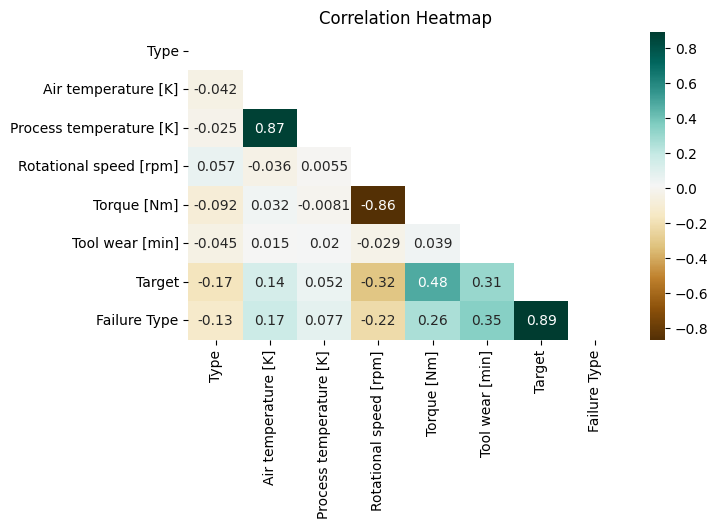

In [26]:
# Correlation Heatmap
plt.figure(figsize=(7,4))
sns.heatmap(data=df_pre.corr(), mask=np.triu(df_pre.corr()), annot=True, cmap='BrBG')
plt.title('Correlation Heatmap')
plt.show()

Unsurprisingly, we observe that the features related to temperature, as well as those related to
power, are widely correlated. Furthermore, Tool Wear correlates well with both of our targets,
confirming what we have observed by studying PCA. Finally, a less strong correlation is also
observed between the torsion and the two targets.

## **Binary task** <a id="binary"></a> 

In [27]:
# train-validation-test split
X, y = df_pre[features], df_pre[['Target', 'Failure Type']]
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, shuffle=True, random_state=0)

In [28]:
def classification(model, X_train, y_train, X_val, y_val):
    t = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    elapsed = time.time() - t
    print(f'Elapsed time: {elapsed:.4f} s')

    accuracy = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    f2 = fbeta_score(y_val, y_pred, beta=2)

    print('Validation Accuracy:', accuracy)
    print('Validation ROC AUC Score:', auc)
    print('Validation F1 Score:', f1)
    print('Validation F2 Score:', f2)

    return model, accuracy, auc, f1, f2


### Models <a id="binary_models"></a>


In [29]:
models = [
    LogisticRegression(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    SVC(probability=True),
    MLPClassifier(max_iter=500)
]

best_model = None
best_f2_score = 0

In [30]:
# Compare models
for model in models:
    print(f"\nModel: {model.__class__.__name__}")
    trained_model, accuracy, auc, f1, f2 = classification(model, X_train, y_train['Target'], X_val, y_val['Target'])

    if f2 > best_f2_score:
        best_model = trained_model
        best_f2_score = f2

print(f'\nBest model: {best_model.__class__.__name__} with F2 Score: {best_f2_score}')



Model: LogisticRegression
Elapsed time: 0.0347 s
Validation Accuracy: 0.8800339126748622
Validation ROC AUC Score: 0.7644656071545228
Validation F1 Score: 0.6552984165651644
Validation F2 Score: 0.6028686687584043

Model: KNeighborsClassifier
Elapsed time: 0.1795 s
Validation Accuracy: 0.9508266214497668
Validation ROC AUC Score: 0.9437234605724069
Validation F1 Score: 0.8830645161290323
Validation F2 Score: 0.9117402164862615

Model: RandomForestClassifier
Elapsed time: 0.8910 s
Validation Accuracy: 0.9779567613395507
Validation ROC AUC Score: 0.9646593379363166
Validation F1 Score: 0.9445628997867804
Validation F2 Score: 0.9433560477001703

Model: SVC
Elapsed time: 3.1903 s
Validation Accuracy: 0.9461636286562103
Validation ROC AUC Score: 0.9128419855152452
Validation F1 Score: 0.8638799571275455
Validation F2 Score: 0.860008536064874

Model: MLPClassifier
Elapsed time: 18.6866 s
Validation Accuracy: 0.9559135226791013
Validation ROC AUC Score: 0.9285195363977338
Validation F1 Score

In [31]:
# Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test['Target'], y_test_pred)
test_auc = roc_auc_score(y_test['Target'], y_test_pred)
test_f1 = f1_score(y_test['Target'], y_test_pred)
test_f2 = fbeta_score(y_test['Target'], y_test_pred, beta=2)

print(f'\nTest Accuracy: {test_accuracy}')
print(f'Test ROC AUC Score: {test_auc}')
print(f'Test F1 Score: {test_f1}')
print(f'Test F2 Score: {test_f2}')



Test Accuracy: 0.98007630351844
Test ROC AUC Score: 0.9735331293241085
Test F1 Score: 0.9515962924819773
Test F2 Score: 0.9581086686022398


In [32]:
# Permutation feature importance
perm_importance = permutation_importance(best_model, X_val, y_val['Target'])
feature_importance = pd.Series(perm_importance.importances_mean, index=features)
feature_importance.sort_values(ascending=False, inplace=True)


C:\Users\Miflow\AppData\Local\Temp\ipykernel_3964\1643347983.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_importance.index, palette='viridis')


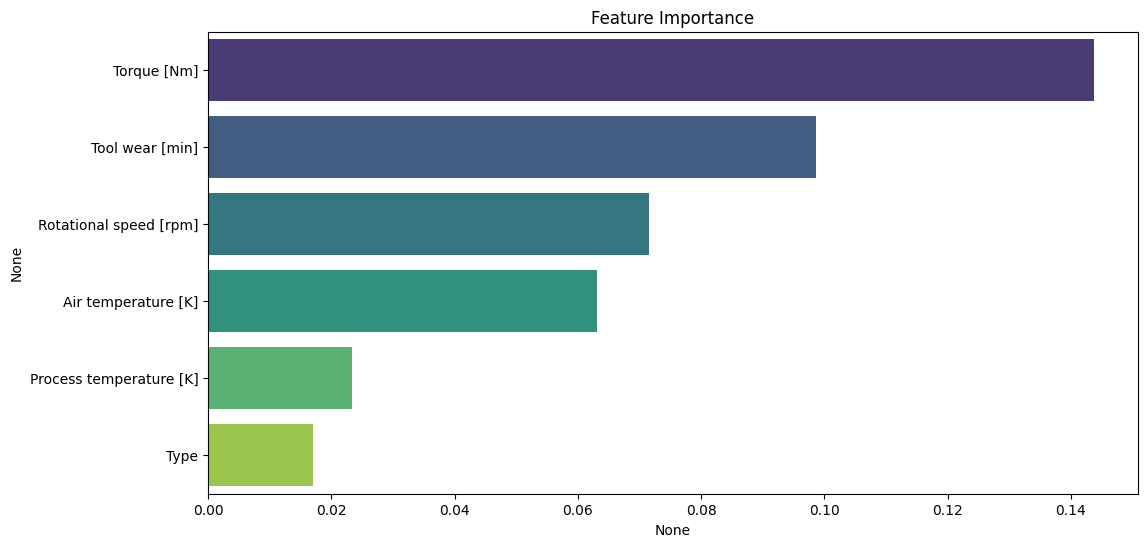

In [33]:
# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance, y=feature_importance.index, palette='viridis')
plt.title('Feature Importance')
plt.show()


In [34]:
# Plotting function
def plot_predictions(y_true, y_pred, title='Predictions vs Actual'):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true.reset_index(drop=True), label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='--')
    plt.xlabel('Samples')
    plt.ylabel('Machine Failure')
    plt.title(title)
    plt.legend()
    plt.show()


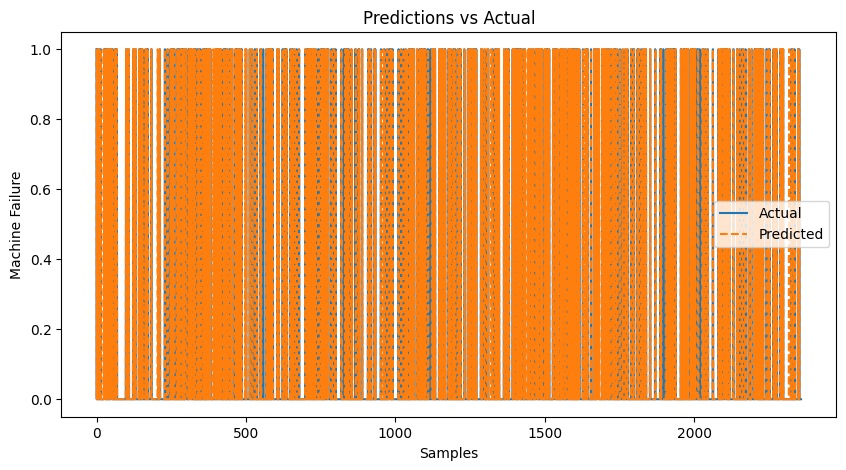

In [35]:
# Plot results
plot_predictions(y_test['Target'], y_test_pred)


In [36]:
# Save results
results = {
    'test_accuracy': test_accuracy,
    'test_auc': test_auc,
    'test_f1': test_f1,
    'test_f2': test_f2
}

results_df = pd.DataFrame([results])
results_df.to_csv('results.csv', index=False)


In [38]:
import joblib
import pickle

# Save the best model using joblib
joblib.dump(best_model, 'best_model.pkl')
print(f'\nBest model saved as best_model.pkl')


Best model saved as best_model.pkl


In [39]:
from sklearn.preprocessing import StandardScaler

# Load the model
loaded_model = joblib.load('best_model.pkl')
print('Model loaded from best_model.pkl')

# Define the feature values for a single machine (replace with actual values)
machine_data = {
    'Type': 'M',
    'Air temperature [K]': 300.0,
    'Process temperature [K]': 310.0,
    'Rotational speed [rpm]': 1500.0,
    'Torque [Nm]': 40.0,
    'Tool wear [min]': 20.0
}

# Convert the machine data to a DataFrame
machine_df = pd.DataFrame([machine_data])

# Encode the 'Type' column
types = {'L': 0, 'M': 1, 'H': 2}
machine_df['Type'].replace(to_replace=types, inplace=True)

# Select numeric features for scaling
num_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Load the scaler used during training
scaler = StandardScaler()
scaler.fit(df_pre[num_features])  # Assuming df_pre is your preprocessed training DataFrame

# Scale the numeric features
machine_df[num_features] = scaler.transform(machine_df[num_features])

# Predict using the loaded model
prediction = loaded_model.predict(machine_df)
probability = loaded_model.predict_proba(machine_df)

# Decode the prediction if necessary
causes = {0: 'No Failure', 1: 'Power Failure', 2: 'Overstrain Failure', 3: 'Heat Dissipation Failure', 4: 'Tool Wear Failure'}
predicted_cause = causes[prediction[0]]

print(f'Predicted Failure Cause: {predicted_cause}')
print(f'Prediction Probability: {probability[0]}')

Model loaded from best_model.pkl
Predicted Failure Cause: Power Failure
Prediction Probability: [0.41 0.59]
